# Influence of hyperparameters

In [1]:
import pandas as pd

import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

import sys
sys.path.append("../..")
from experiments.evaluation import Evaluator
from experiments.modelgeneration import ModelGenerator

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /vscode/vscode-server/bin/linux-x64/2ccd690cbff1569e4a83d7c43d45101f817401dc


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdatesCpp = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [3]:
# initialize objects
evaluator = Evaluator(interface_capnp, processDataUpdatesCpp)

In [4]:
metricsCat = ["complexity", "valueSetF1"]
metricsNum = ["complexity", "predictionRMSE"]

## Individual test

### Generate event log

In [3]:
!capnp convert json:binary ../../cpp-tool/capnproto/interface.capnp RuleModel < SSDppModel.json > /tmp/SSDppModel.bin
with open("/tmp/SSDppModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdatesCpp.modelToString(model).wait().string)

IF light = red THEN color IN {blue}
IF 70.000000 <= length THEN speed = 42.000000
IF length <= 25.000000 THEN speed = 11.000000
IF 50.000000 <= speed THEN color IN {orange}
IF light = green THEN length = 60.000000



In [4]:
logWithUsage = processDataUpdatesCpp.generateEventLog(model=model, numberOfTraces=50, traceLength=10).wait()
log = logWithUsage.log
ruleUsage = logWithUsage.ruleUsage

In [5]:
updateRules = [x.rule.updateRule for x in ruleUsage]
frequencies = [x.frequency for x in ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "speed",\n  valueRule = (constant...        104
1  ( variable = "color",\n  valueSetRule = (set =...        164
2  ( variable = "speed",\n  valueRule = (constant...         88
3  ( variable = "color",\n  valueSetRule = (set =...        131
4  ( variable = "length",\n  valueRule = (constan...        163

### Add noise

In [6]:
from experiments.addnoise import addSwapNoiseToMessage
noisyLog = addSwapNoiseToMessage(log, proportion=0.1)

Constructing traces: 100%|██████████| 50/50 [00:00<00:00, 1918.59it/s]


### Find model with my method

In [14]:
cppModel = processDataUpdatesCpp.findModel(noisyLog, conditionCount=10).wait().model
print(processDataUpdatesCpp.modelToString(cppModel).wait().string)

IF light = red THEN color IN {blue}
IF light = green THEN length = 60.000000
IF length <= 26.200000 THEN speed = 11.000000
IF 54.500000 <= speed THEN color IN {orange}
IF 74.100000 <= length THEN speed = 42.000000



## Evaluating experiments

In [5]:
tableCat = evaluator.createExperimentTable("hyperparameterCategorical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-my-model\.bin",
    ["noiseProportion", "conditionCount", "modelID", "logVariant"])
tableNum = evaluator.createExperimentTable("hyperparameterNumerical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-my-model\.bin",
    ["noiseProportion", "conditionCount", "modelID", "logVariant"])

In [6]:
evaluator.addMetricsToExperimentTable("hyperparameterCategorical", tableCat, metricsCat)
evaluator.addMetricsToExperimentTable("hyperparameterNumerical", tableNum, metricsNum)

Computing predictionRMSE: 100%|██████████| 1500/1500 [01:17<00:00, 19.31it/s]


In [7]:
tableCat.to_csv("hyperparameterTableCat.csv")
tableNum.to_csv("hyperparameterTableNum.csv")

## Visualizing experiments

In [5]:
tableCat = pd.read_csv("hyperparameterTableCat.csv")
tableNum = pd.read_csv("hyperparameterTableNum.csv")

In [6]:
# fix datatypes
tableCat.conditionCount = pd.to_numeric(tableCat.conditionCount)
tableCat.noiseProportion = pd.to_numeric(tableCat.noiseProportion)

tableNum.conditionCount = pd.to_numeric(tableNum.conditionCount)
tableNum.noiseProportion = pd.to_numeric(tableNum.noiseProportion)

In [7]:
# aggregate data for plot
aggregationColumns = ["conditionCount", "noiseProportion"]

catAggregated = evaluator.aggregateMetrics(tableCat, aggregationColumns, metricsCat)
numAggregated = evaluator.aggregateMetrics(tableNum, aggregationColumns, metricsNum)

### Plots

#### Categorical target

In [8]:
evaluator.plotHyperparameterExperiment(catAggregated, "complexity", "conditionCount", "noiseProportion")

In [9]:
evaluator.plotHyperparameterExperiment(catAggregated, "valueSetF1", "conditionCount", "noiseProportion")

#### Numerical target

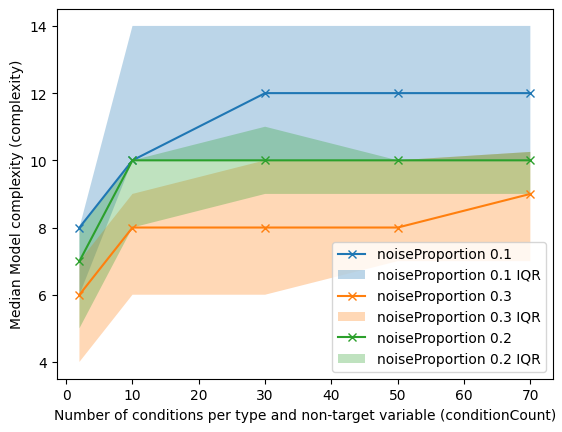

In [10]:
evaluator.plotHyperparameterExperiment(numAggregated, "complexity", "conditionCount", "noiseProportion")

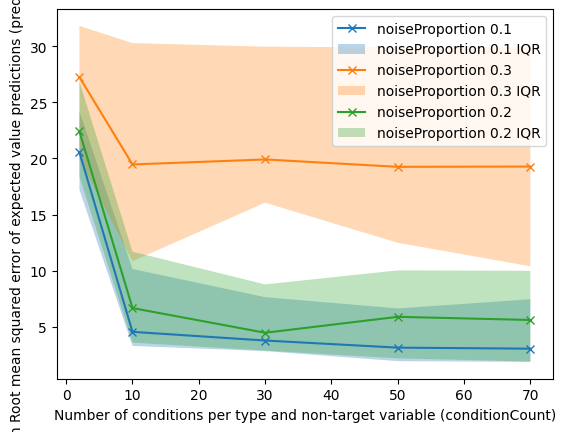

In [11]:
evaluator.plotHyperparameterExperiment(numAggregated, "predictionRMSE", "conditionCount", "noiseProportion")

### LaTeX exports

In [10]:
def extractMetricForPgfplots(aggregatedTable, metricName, fileName):
    metric = aggregatedTable[metricName]
    metric = metric.drop([0.3], level=1, axis="index", errors="ignore")
    metric["lowIqr"] = metric["midIqr"] - metric["lowIqr"]
    metric["highIqr"] = metric["highIqr"] - metric["midIqr"]
    metric = metric.rename(columns={"lowIqr": "relative lowIqr", "highIqr": "relative highIqr"})
    metric.to_csv(fileName)

In [11]:
extractMetricForPgfplots(catAggregated, "valueSetF1", "prediction-f1-condition-count.csv")

In [12]:
extractMetricForPgfplots(numAggregated, "predictionRMSE", "prediction-rmse-condition-count.csv")